# <u>Deep Love</u>

# Base Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import tensorflow_hub as hub
import spacy
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history, metrics = ['accuracy', 'F1']):
  plt.figure(figsize=(14, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.history[metric], color=colors[0], label='train')
    plt.plot(history.history['val_'+metric],
             color=colors[0], linestyle="--", label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Load Data

In [3]:
TRAIN_SIZE = 0.85
PATH = 'data/'

#"Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"
classes = ["Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]
data_train = pd.read_csv(PATH+'tweets_train.csv')

train_data = data_train.sample(frac=1).reset_index(drop=True)
train_data, val_data = train_data.iloc[:int(TRAIN_SIZE*len(train_data)), :], train_data.iloc[int(TRAIN_SIZE*len(train_data)):, :]

print(data_train.shape)
print(train_data.shape)
print(val_data.shape)

(2256, 10)
(1917, 10)
(339, 10)


# Exploración de datos

In [4]:
from random import randint

row_num = data_train.shape[0]
initial = randint(0, row_num-5)
for i in range(initial, initial+5):
    print("Tweet", i+1)
    print(data_train["text"].iloc[i])
    print("Odio:", data_train["Odio"].iloc[i], " "
          "Mujeres:", data_train["Mujeres"].iloc[i], " "
          "LGBT:", data_train["Comunidad LGBTQ+"].iloc[i], " ",
          "Migrantes:", data_train["Comunidades Migrantes"].iloc[i], " ",
          "Pueblos Originarios:", data_train["Pueblos Originarios"].iloc[i])
    print()

Tweet 224
@CHVNoticias Das pena, eres agresiva   discriminadora, triste feminista progre, te crees superior y además fome
Odio: 3  Mujeres: 3  LGBT: 0   Migrantes: 0   Pueblos Originarios: 0

Tweet 225
@Carlos20018264 @KeikoFujimori Pobre y triste indio rosquete. Ve a follar con mototaxistas, que es a lo único que aspiras, oye insignificante, poca cosa y muerto de hambre. El taper lo necesitas para que tengas qué tragar y dejes de pedir limosnas en las esquinas. Marginal, regresa a tu puna a arar la tierra😂
Odio: 3  Mujeres: 0  LGBT: 1   Migrantes: 0   Pueblos Originarios: 3

Tweet 226
@MICHILEQUERIDO3 @sebastianpinera @allamand @GalliJF Vamos patriotas chile es nuestro sus recursos y sus empleos...la calidad debe comerzar por casa no trayendo más gente inmigrante q ya no sabe ni como subsistir ni dónde dormir y a quienes en el norte se les está regalando casas
Odio: 2  Mujeres: 0  LGBT: 0   Migrantes: 3   Pueblos Originarios: 0

Tweet 227
@PlazaColonia Y la opinión del negrito no cuen

In [5]:
MIN_VOTOS = 2

num_odio = data_train["Odio"][data_train["Odio"] >= MIN_VOTOS].count()
num_mujeres = data_train["Mujeres"][data_train["Mujeres"] >= MIN_VOTOS].count()
num_lgbt = data_train["Comunidad LGBTQ+"][data_train["Comunidad LGBTQ+"] >= MIN_VOTOS].count()
num_migrantes = data_train["Comunidades Migrantes"][data_train["Comunidades Migrantes"] >= MIN_VOTOS].count()
num_pueblos = data_train["Pueblos Originarios"][data_train["Pueblos Originarios"] >= MIN_VOTOS].count()
sin_categoria = data_train["Odio"][data_train["Odio"] < MIN_VOTOS][data_train["Mujeres"] < MIN_VOTOS][data_train["Comunidad LGBTQ+"] < MIN_VOTOS][data_train["Comunidades Migrantes"] < MIN_VOTOS][data_train["Pueblos Originarios"] < MIN_VOTOS].count()

print("Numero de tweets por categoria:")
print("Odio:", num_odio)
print("Mujeres:", num_mujeres)
print("LGBTQ+:", num_lgbt)
print("Migrantes:", num_migrantes)
print("Pueblos Originarios:", num_pueblos)
print("Sin categoria:", sin_categoria)

num_odio_mujeres = data_train["Mujeres"][data_train["Odio"] >= MIN_VOTOS][data_train["Mujeres"] >= MIN_VOTOS].count()
num_odio_lgbt = data_train["Comunidad LGBTQ+"][data_train["Odio"] >= MIN_VOTOS][data_train["Comunidad LGBTQ+"] >= MIN_VOTOS].count()
num_odio_migrantes = data_train["Comunidades Migrantes"][data_train["Odio"] >= MIN_VOTOS][data_train["Comunidades Migrantes"] >= MIN_VOTOS].count()
num_odio_pueblos = data_train["Pueblos Originarios"][data_train["Odio"] >= MIN_VOTOS][data_train["Pueblos Originarios"] >= MIN_VOTOS].count()
odio_sin_categoria = data_train["Odio"][data_train["Odio"] >= MIN_VOTOS][data_train["Mujeres"] < MIN_VOTOS][data_train["Comunidad LGBTQ+"] < MIN_VOTOS][data_train["Comunidades Migrantes"] < MIN_VOTOS][data_train["Pueblos Originarios"] < MIN_VOTOS].count()


print("\nNumero de tweets de odio hacia:")
print("Mujeres:", num_odio_mujeres, "(", 100 * num_odio_mujeres/num_mujeres, "%)")
print("LGBTQ+:", num_odio_lgbt, "(", 100 * num_odio_lgbt/num_lgbt, "%)")
print("Migrantes:", num_odio_migrantes, "(", 100 * num_odio_migrantes/num_migrantes, "%)")
print("Pueblos Originarios:", num_odio_pueblos, "(", 100 * num_odio_pueblos/num_pueblos, "%)")
print("Sin categoria:", odio_sin_categoria, "(", 100 * odio_sin_categoria/sin_categoria, "%)")

Numero de tweets por categoria:
Odio: 999
Mujeres: 468
LGBTQ+: 155
Migrantes: 327
Pueblos Originarios: 290
Sin categoria: 1009

Numero de tweets de odio hacia:
Mujeres: 297 ( 63.46153846153846 %)
LGBTQ+: 129 ( 83.2258064516129 %)
Migrantes: 291 ( 88.9908256880734 %)
Pueblos Originarios: 274 ( 94.48275862068965 %)
Sin categoria: 42 ( 4.162537165510407 %)


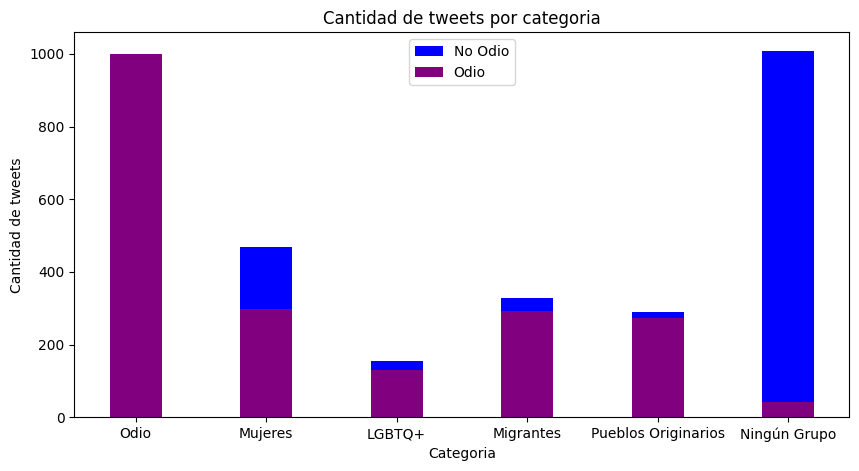

In [6]:
tweets_by_category = [num_odio, num_mujeres, num_lgbt, num_migrantes, num_pueblos, sin_categoria]
tweets_by_category_odio = [num_odio, num_odio_mujeres, num_odio_lgbt, num_odio_migrantes, num_odio_pueblos, odio_sin_categoria]
categories = ["Odio", "Mujeres", "LGBTQ+", "Migrantes", "Pueblos Originarios", "Ningún Grupo"]

plt.figure(figsize=(10, 5))
plt.bar(categories, tweets_by_category, color='blue', width=0.4)
plt.bar(categories, tweets_by_category_odio, color='purple', width=0.4)
plt.title("Cantidad de tweets por categoria")
plt.xlabel("Categoria")
plt.ylabel("Cantidad de tweets")
# add a legend
plt.legend(["No Odio", "Odio"])
plt.show()

# Preprocess Data

## Conversión a Multi-Hot Encoding

In [7]:
MIN_VOTOS = 2

if MIN_VOTOS == 3:
    # Considerar que un dato pertenece solo si las 3 personas pusieron que pertenece
    train_data['Odio'] = np.where(train_data['Odio'] == 3, 1, 0)
    val_data['Odio'] = np.where(val_data['Odio'] == 3, 1, 0)
    train_data['Mujeres'] = np.where(train_data['Mujeres'] == 3, 1, 0)
    val_data['Mujeres'] = np.where(val_data['Mujeres'] == 3, 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where(train_data['Comunidad LGBTQ+'] == 3, 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where(val_data['Comunidad LGBTQ+'] == 3, 1, 0)
    train_data['Comunidades Migrantes'] = np.where(train_data['Comunidades Migrantes'] == 3, 1, 0)
    val_data['Comunidades Migrantes'] = np.where(val_data['Comunidades Migrantes'] == 3, 1, 0)
    train_data['Pueblos Originarios'] = np.where(train_data['Pueblos Originarios'] == 3, 1, 0)
    val_data['Pueblos Originarios'] = np.where(val_data['Pueblos Originarios'] == 3, 1, 0)   
elif MIN_VOTOS == 2:
    train_data['Odio'] = np.where((train_data['Odio'] == 3) | (train_data['Odio'] == 2), 1, 0)
    val_data['Odio'] = np.where((val_data['Odio'] == 3) | (val_data['Odio'] == 2), 1, 0)
    train_data['Mujeres'] = np.where((train_data['Mujeres'] == 3) | (train_data['Mujeres'] == 2), 1, 0)
    val_data['Mujeres'] = np.where((val_data['Mujeres'] == 3) | (val_data['Mujeres'] == 2), 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where((train_data['Comunidad LGBTQ+'] == 3) | (train_data['Comunidad LGBTQ+'] == 2), 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where((val_data['Comunidad LGBTQ+'] == 3) | (val_data['Comunidad LGBTQ+'] == 2), 1, 0)
    train_data['Comunidades Migrantes'] = np.where((train_data['Comunidades Migrantes'] == 3) | (train_data['Comunidades Migrantes'] == 2), 1, 0)
    val_data['Comunidades Migrantes'] = np.where((val_data['Comunidades Migrantes'] == 3) | (val_data['Comunidades Migrantes'] == 2), 1, 0)
    train_data['Pueblos Originarios'] = np.where((train_data['Pueblos Originarios'] == 3) | (train_data['Pueblos Originarios'] == 2), 1, 0)
    val_data['Pueblos Originarios'] = np.where((val_data['Pueblos Originarios'] == 3) | (val_data['Pueblos Originarios'] == 2), 1, 0)

## Cleaning

In [8]:
import unidecode
import spacy_spanish_lemmatizer

stemmer = SnowballStemmer("spanish")
nlp = spacy.load("es_core_news_lg")
#nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
stop_words = stopwords.words("spanish")

def clean_text(text, len_words):
    TEXT_CLEANING_RE = "@\S+" # separado porque solo agarraba la primera etiqueta
    TEXT_CLEANING_RE2 = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
    TEXT_CLEANING_RE_EXTRA = "[^\w\s]"
    if len_words == 1:
        text = re.sub(r'\b\w{1}\b', '', str(text).lower()).strip()
    elif len_words == 2:
        text = re.sub(r'\b\w{1,2}\b', '', str(text).lower()).strip()
    elif len_words == 3:
        text = re.sub(r'\b\w{1,3}\b', '', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE2, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE_EXTRA, ' ', str(text).lower()).strip()
    return text

def preprocess(text,cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=1):
    text = unidecode.unidecode(text)
    if cleaning:
        text = clean_text(text, len_words)
    tokens = []
    for token in text.split():
        if (not stopwords) or (stopwords and (token not in stop_words)):
            if stemming:
                tokens.append(stemmer.stem(token))
            elif lemmatizer:
                doc = nlp(token)
                tokens.append(unidecode.unidecode(doc[0].lemma_))
            else:
                tokens.append(token)    
    text2 = " ".join(tokens)
    if cleaning:
        text2 = clean_text(text2, len_words)
    return text2

c:\Users\joaco\anaconda3\envs\conda_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pruebas de preprocesado

In [9]:
import random

tweet = train_data['text'][random.randint(0, len(train_data))]
#tweet = "@jalessandri @RicardoVenegas7 @hola Estos wueones extranjero haitianos,peruanos, venezolanos y los más ladrones .cubanos .vinieron a echar el país,,,toda está gente vende en las calles y puras cochinadas como vendiendo almuerzo pobladas en la catedral fuera de este país por eso boto RECHAZO....."

print(tweet,"\n")  
print("Sin stopwords:",preprocess(tweet, stopwords=False))
print("Con stemming:",preprocess(tweet, cleaning=True, stopwords=False, stemming=True))
print("Con lematizacion:",preprocess(tweet, cleaning=True, stopwords=False, stemming=False, lemmatizer=True, len_words=1))

Y casi que todos los días. Hombretones solos, de países donde la mujer no vale nada a menos que un hombre la "proteja" (sea su dueño), que se rigen por leyes involucionistas, ¿qué esperamos, qué se integren por ciencia infusa?. La evolución tiene sus tiempos. https://t.co/2MMpgXLrCy 

Sin stopwords: casi que todos los dias hombretones solos de paises donde la mujer no vale nada menos que un hombre la proteja sea su dueno que se rigen por leyes involucionistas que esperamos que se integren por ciencia infusa la evolucion tiene sus tiempos
Con stemming: casi que tod los dias hombreton sol de pais dond la muj no val nad men que un hombr la protej sea su duen que se rig por ley involucion que esper que se integr por cienci infus la evolucion tien sus tiemp
Con lematizacion: casi que todo el dia hombreton solo de pais donde el mujer no valer nada menos que uno hombre el proteger ser su dueno que el regir por ley involucionista que esperar que el integrar por ciencia infus el evolucion tener

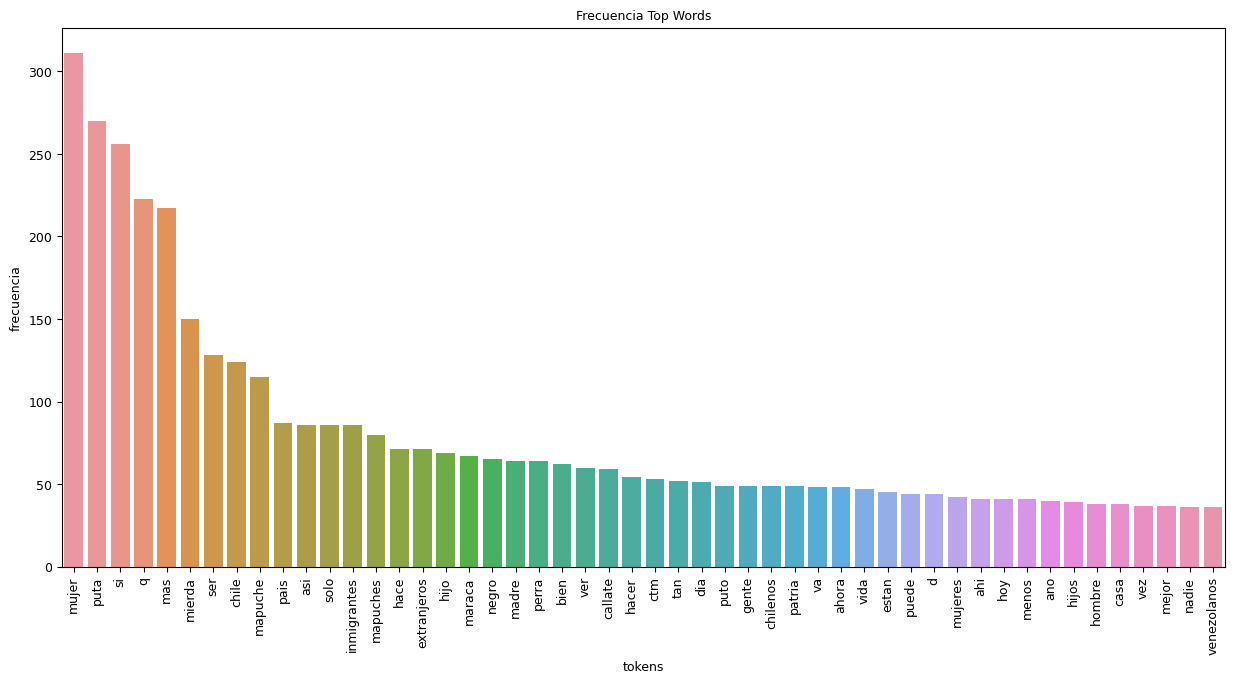

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

n_top_words = 50

tweets= [preprocess(tweet, cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=0).split() for tweet in train_data['text'].values]

top_words = Counter([item for sublist in [tweet for tweet in tweets] for item in sublist]).most_common(n_top_words)

fig, ax = plt.subplots(figsize=(15,7),nrows=1)
ax.set_title('Frecuencia Top Words',fontsize=9)
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words])
ax.set_xlabel("tokens",fontsize=9)
ax.set_ylabel("frecuencia",fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=90)
plt.show()

# Definición de modelo y datos a usar

In [11]:
CLEANING = True
STOPWORDS = True
STEMMING = False
LEMMATIZER = False
LEN_WORDS = 2

train_tweets = [preprocess(tweet, cleaning=CLEANING, stopwords=STOPWORDS, stemming=STEMMING, lemmatizer=LEMMATIZER, len_words=LEN_WORDS) for tweet in train_data['text'].values]
val_tweets = [preprocess(tweet) for tweet in val_data['text'].values]
y_train_categorias = train_data[classes].values
y_val_categorias = val_data[classes].values

print(y_train_categorias.shape)
print(y_val_categorias.shape)

(1917, 4)
(339, 4)


In [12]:
import tensorflow_addons as tfa
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1',average='macro', num_classes=len(classes)),
      tf.metrics.Recall(name='recall')
]

c:\Users\joaco\anaconda3\envs\conda_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [13]:
from transformers import WordpieceTokenizer, BasicTokenizer, BertTokenizer
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(bert_path, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [14]:
def prepare_input_for_bert(texts, bert_tokenizer, max_seq_len):
  x, y, z =[],[], []
  for text in texts:
    tokens = bert_tokenizer.tokenize(text)
    tokens = tokens[:min(len(tokens),max_seq_len-2)]
    tokens = ["[CLS]"]+tokens+["[SEP]"]
    token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_len-len(token_ids))
    input_mask = ([1] * len(token_ids)) + ([0] *  (max_seq_len - len(token_ids)))
    input_type = ([0] * (len(token_ids)-1)) + [1] + ([0] *  (max_seq_len - len(token_ids)))
    x.append(np.array(input_ids))
    y.append(np.array(input_mask))
    z.append(np.array(input_type))
  return [tf.cast(np.array(x),tf.int32), tf.cast(np.array(y),tf.int32), tf.cast(np.array(z),tf.int32)]

In [15]:
def bert_based_model(max_seq_len):
  input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
  input_mask = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_masks")
  input_segments = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_segments")
  pooled_output, sequence_output = bert_layer([input_ids, input_mask, input_segments])
  cls_out = keras.layers.GlobalAveragePooling1D()(sequence_output)
  logits = keras.layers.Dropout(0.7)(cls_out)
  logits = keras.layers.Dense(768)(logits)
  logits = keras.layers.Dense(600)(logits)
  logits = keras.layers.Dropout(0.7)(logits)
  logits = keras.layers.Dense(len(classes), activation="softmax")(logits)
  classifier = keras.Model([input_ids, input_mask, input_segments],logits)

  return classifier

In [16]:
max_seq_len=50
bert_input_train = prepare_input_for_bert(train_tweets,bert_tokenizer,max_seq_len)
bert_input_val = prepare_input_for_bert(val_tweets,bert_tokenizer,max_seq_len)
print(bert_input_train[0].shape)

(1917, 50)


In [17]:
print(bert_input_train[0])

tf.Tensor(
[[  101  7481 24996 ...     0     0     0]
 [  101  2053  9541 ...     0     0     0]
 [  101  2310 13639 ...     0     0     0]
 ...
 [  101  4949 19140 ...     0     0     0]
 [  101 22939 25698 ...     0     0     0]
 [  101  2566  4063 ...     0     0     0]], shape=(1917, 50), dtype=int32)


In [18]:
bert_model = bert_based_model(max_seq_len)
bert_model.summary()
bert_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics = METRICS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 input_segments (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 50, 768)]                 'input_masks[0][0]',        

# Entrenamiento

In [22]:
bert_model = tf.keras.models.load_model('BERT_model/softmax_BERT_4class_F1-0.6267.h5', custom_objects={'KerasLayer':hub.KerasLayer})

In [23]:
if len(classes) == 1:
    metrica_monitoreada = 'val_accuracy'
else:
    metrica_monitoreada = 'val_F1'

print("metrica monitoreada", metrica_monitoreada)

checkpoint_path = 'BERT_based_checkpoints/BERT_based.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor=metrica_monitoreada,mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor=metrica_monitoreada, patience=5, restore_best_weights=True, mode='max')
history_bert_model = bert_model.fit(bert_input_train, y_train_categorias, epochs=80, batch_size=8, validation_data=(bert_input_val, y_val_categorias), callbacks=[es])

metrica monitoreada val_F1
Epoch 1/80
240/240 [==============================] - 36s 109ms/step - loss: 0.0804 - accuracy: 0.8863 - F1: 0.6637 - recall: 0.9479 - val_loss: 0.0661 - val_accuracy: 0.9115 - val_F1: 0.6783 - val_recall: 0.9511
Epoch 2/80
240/240 [==============================] - 25s 106ms/step - loss: 0.0485 - accuracy: 0.8902 - F1: 0.6664 - recall: 0.9612 - val_loss: 0.0973 - val_accuracy: 0.8990 - val_F1: 0.6919 - val_recall: 0.9511
Epoch 3/80
240/240 [==============================] - 24s 102ms/step - loss: 0.0303 - accuracy: 0.8902 - F1: 0.6705 - recall: 0.9650 - val_loss: 0.0820 - val_accuracy: 0.9004 - val_F1: 0.6557 - val_recall: 0.9620
Epoch 4/80
240/240 [==============================] - 25s 102ms/step - loss: 0.0166 - accuracy: 0.8884 - F1: 0.6629 - recall: 0.9650 - val_loss: 0.0918 - val_accuracy: 0.8990 - val_F1: 0.6430 - val_recall: 0.9565
Epoch 5/80
240/240 [==============================] - 25s 102ms/step - loss: 0.0142 - accuracy: 0.8882 - F1: 0.6673 - rec

In [24]:
bert_model.save('BERT_model/softmax_BERT_'+str(len(classes))+'class_F1-{:.4f}.h5'.format((history_bert_model.history['val_F1'][-1])))

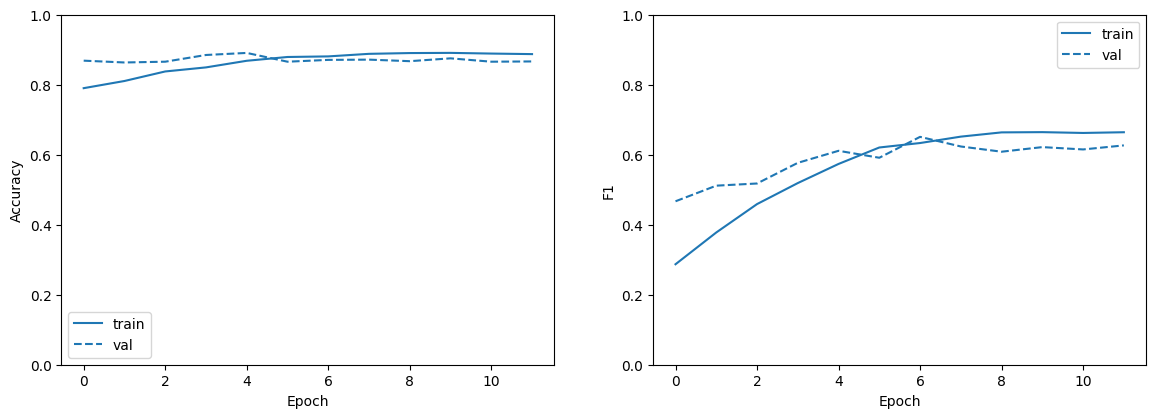

In [21]:
plot_metrics(history_bert_model)

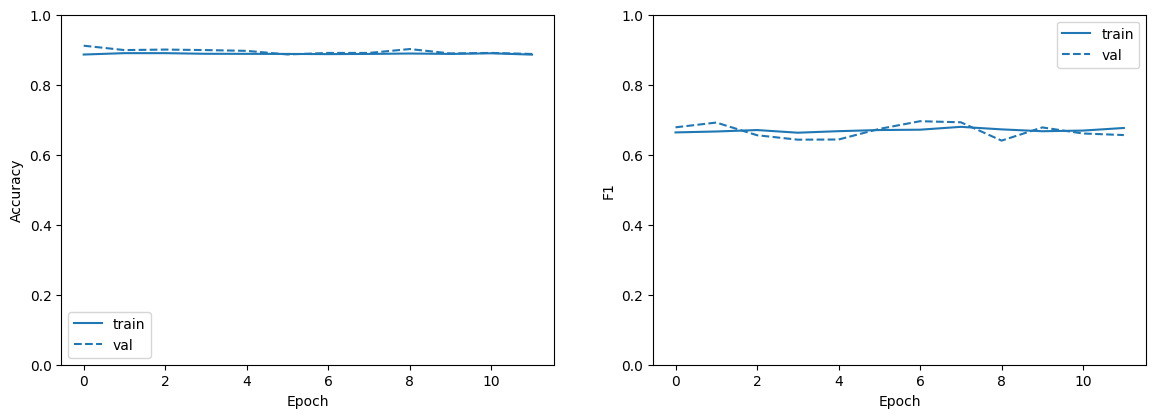

In [25]:
plot_metrics(history_bert_model)

# Predicciones

In [109]:
bert_model = keras.models.load_model('BERT_model/long_train_BERT_5class_F1-0.5997.h5', custom_objects={'KerasLayer':hub.KerasLayer})
test_data = pd.read_csv('data/public_test.csv')
test_tweets = [preprocess(tweet, cleaning=CLEANING, stopwords=STOPWORDS, stemming=STEMMING, lemmatizer=LEMMATIZER, len_words=LEN_WORDS) for tweet in test_data['text'].values]
bert_input_test = prepare_input_for_bert(test_tweets,bert_tokenizer,max_seq_len)

y_pred_categorias = bert_model.predict(bert_input_test)
for row in y_pred_categorias:
    for i in range(len(classes)):
        if row[i] > 0.5:
            row[i] = 1
        else:
            row[i] = 0
y_pred_categorias = pd.DataFrame(y_pred_categorias, columns=[classes])

72/72 [==============================] - 4s 50ms/step


In [185]:
def contar_odio(nombre_columna):
    contador = 0
    for i in range(len(y_pred_categorias)):
        if y_pred_categorias[nombre_columna].iloc[i].item()==1:
            if y_pred_categorias["Odio"].iloc[i].item()==1:
                contador += 1
    return contador 

print(list(y_pred_categorias.sum(axis=0)))

[1252.0, 483.0, 248.0, 328.0, 330.0]


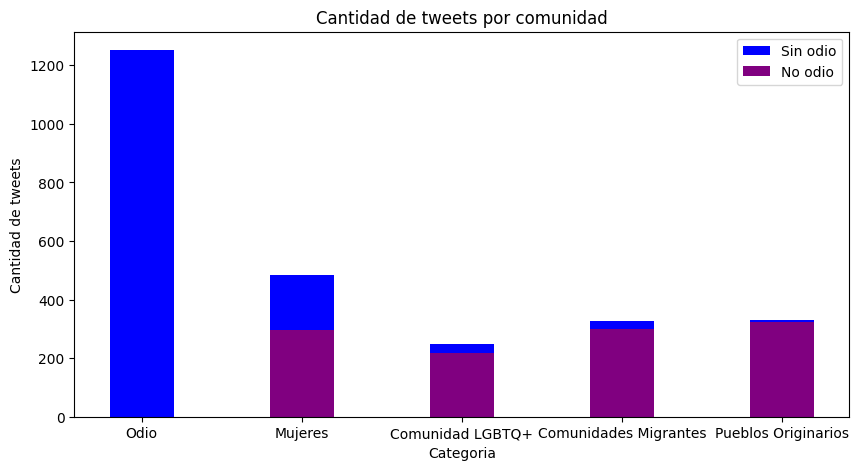

In [191]:
[num_odio, num_mujeres, num_lgbt, num_migrantes, num_pueblos] =list(y_pred_categorias.sum(axis=0))
odio_mujeres = contar_odio("Mujeres")
odio_lgbt = contar_odio("Comunidad LGBTQ+")
odio_migrantes = contar_odio("Comunidades Migrantes")
odio_pueblos = contar_odio("Pueblos Originarios")

# plot the data of each community with odio and without odio
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(classes, [0, num_mujeres, num_lgbt, num_migrantes, num_pueblos], label='No odio', color='blue', width=0.4)
ax.bar(classes, [num_odio, odio_mujeres, odio_lgbt, odio_migrantes, odio_pueblos], label='Odio', color='purple', width=0.4)
ax.set_ylabel('Cantidad de tweets')
ax.set_xlabel('Categoria')
ax.set_title('Cantidad de tweets por comunidad')
ax.legend()
plt.show()


In [ ]:
y_pred_categorias["tweet_id"] = test_data["tweet_id"]
y_pred_categorias.to_csv('predicciones.csv', index=False)
y_pred_categorias